# Image Background Removal with U^2-Net and OpenVINO™

This notebook demonstrates background removal in images using U$^2$-Net and OpenVINO.

For more information about U$^2$-Net, including source code and test data, see the [Github page](https://github.com/xuebinqin/U-2-Net) and the research paper: [U^2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/pdf/2005.09007.pdf).

The PyTorch U$^2$-Net model is converted to OpenVINO IR format. The model source is available [here](https://github.com/xuebinqin/U-2-Net).

## Prepare

### Import the PyTorch Library and U$^2$-Net

In [1]:
!pip install -q gdown

In [2]:
import os
import time
from collections import namedtuple
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, FileLink, display
from model.u2net import U2NET, U2NETP
from openvino.runtime import Core
from openvino.tools import mo

### Settings

This tutorial supports using the original U$^2$-Net salient object detection model, as well as the smaller U2NETP version. Two sets of weights are supported for the original model: salient object detection and human segmentation.

In [3]:
IMAGE_DIR = "../data/image/"
model_config = namedtuple("ModelConfig", ["name", "url", "model", "model_args"])

u2net_lite = model_config(
    name="u2net_lite",
    url="https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy",
    model=U2NETP,
    model_args=(),
)
u2net = model_config(
    name="u2net",
    url="https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ",
    model=U2NET,
    model_args=(3, 1),
)
u2net_human_seg = model_config(
    name="u2net_human_seg",
    url="https://drive.google.com/uc?id=1-Yg0cxgrNhHP-016FPdp902BR-kSsA4P",
    model=U2NET,
    model_args=(3, 1),
)

# Set u2net_model to one of the three configurations listed above.
u2net_model = u2net_lite

In [4]:
# The filenames of the downloaded and converted models.
MODEL_DIR = "model"
model_path = Path(MODEL_DIR) / u2net_model.name / Path(u2net_model.name).with_suffix(".pth")

### Load the U$^2$-Net Model

The U$^2$-Net human segmentation model weights are stored on Google Drive. They will be downloaded if they are not present yet. The next cell loads the model and the pre-trained weights.

In [5]:
if not model_path.exists():
    import gdown

    os.makedirs(name=model_path.parent, exist_ok=True)
    print("Start downloading model weights file... ")
    with open(model_path, "wb") as model_file:
        gdown.download(url=u2net_model.url, output=model_file)
        print(f"Model weights have been downloaded to {model_path}")

In [6]:
# Load the model.
net = u2net_model.model(*u2net_model.model_args)
net.eval()

# Load the weights.
print(f"Loading model weights from: '{model_path}'")
net.load_state_dict(state_dict=torch.load(model_path, map_location="cpu"))

torch.onnx.export(net, torch.zeros((1,3,512,512)), "u2net.onnx")

Loading model weights from: 'model/u2net_lite/u2net_lite.pth'


/home/ea/work/notebooks_convert/notebooks_conv_env/lib/python3.8/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/ea/work/notebooks_convert/notebooks_conv_env/lib/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ea/work/notebooks_convert/notebooks_conv_env/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node,

## Convert PyTorch U$^2$-Net model to OpenVINO IR

### Convert Pytorch model to OpenVINO IR Format

Use Model Optimizer Python API to convert the Pytorch model to OpenVINO IR format, with `FP16` precision. We add the mean values to the model and scale the input with the standard deviation with `scale_values` parameter. With these options, it is not necessary to normalize input data before propagating it through the network. The mean and standard deviation values can be found in the [dataloader](https://github.com/xuebinqin/U-2-Net/blob/master/data_loader.py) file in the [U^2-Net repository](https://github.com/xuebinqin/U-2-Net/) and multiplied by 255 to support images with pixel values from 0-255.

For more information, refer to the [Model Optimizer Developer Guide](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html).

Executing the following command may take a while.

In [7]:
model_ir = mo.convert_model(
    "u2net.onnx",
    mean_values=[123.675, 116.28 , 103.53],
    scale_values=[58.395, 57.12 , 57.375],
    compress_to_fp16=True
)

## Load and Pre-Process Input Image

While OpenCV reads images in `BGR` format, the OpenVINO IR model expects images in `RGB`. Therefore, convert the images to `RGB`, resize them to `512 x 512` and transpose the dimensions to the format that is expected by the OpenVINO IR model.

In [8]:
IMAGE_PATH = Path(IMAGE_DIR) / "coco_hollywood.jpg"
image = cv2.cvtColor(
    src=cv2.imread(filename=str(IMAGE_PATH)),
    code=cv2.COLOR_BGR2RGB,
)

resized_image = cv2.resize(src=image, dsize=(512, 512))
# Convert the image shape to a shape and a data type expected by the network
# for OpenVINO IR model: (1, 3, 512, 512).
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

## Do Inference on OpenVINO IR Model

Load the OpenVINO IR model to OpenVINO Runtime and do inference.

In [9]:
# Load the network to OpenVINO Runtime.
ie = Core()
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")
# Get the names of input and output layers.
input_layer_ir = compiled_model_ir.input(0)
output_layer_ir = compiled_model_ir.output(0)

# Do inference on the input image.
start_time = time.perf_counter()
result = compiled_model_ir([input_image])[output_layer_ir]
end_time = time.perf_counter()
print(
    f"Inference finished. Inference time: {end_time-start_time:.3f} seconds, "
    f"FPS: {1/(end_time-start_time):.2f}."
)

Inference finished. Inference time: 0.103 seconds, FPS: 9.74.


## Visualize Results

Show the original image, the segmentation result, and the original image with the background removed. 

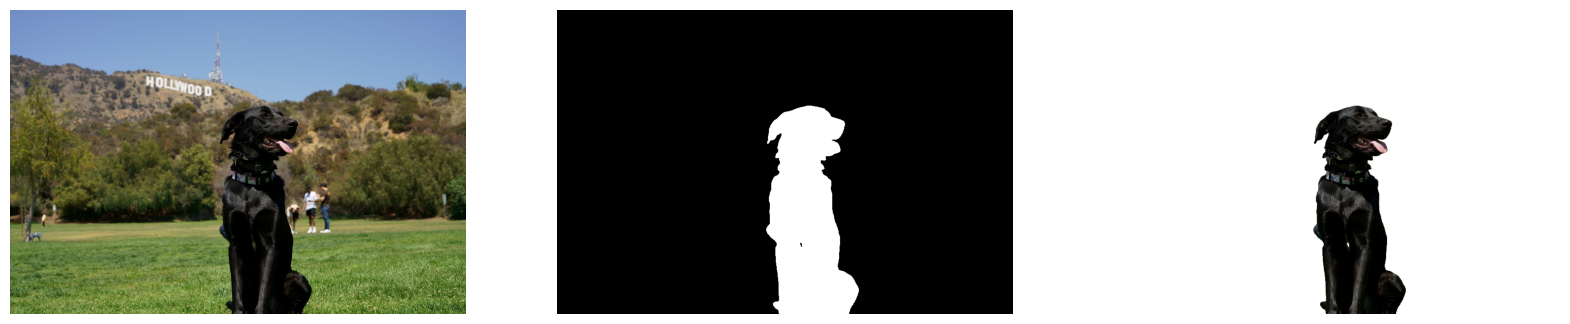

In [10]:
# Resize the network result to the image shape and round the values
# to 0 (background) and 1 (foreground).
# The network result has (1,1,512,512) shape. The `np.squeeze` function converts this to (512, 512).
resized_result = np.rint(
    cv2.resize(src=np.squeeze(result), dsize=(image.shape[1], image.shape[0]))
).astype(np.uint8)

# Create a copy of the image and set all background values to 255 (white).
bg_removed_result = image.copy()
bg_removed_result[resized_result == 0] = 255

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
ax[0].imshow(image)
ax[1].imshow(resized_result, cmap="gray")
ax[2].imshow(bg_removed_result)
for a in ax:
    a.axis("off")

### Add a Background Image

In the segmentation result, all foreground pixels have a value of 1, all background pixels a value of 0. Replace the background image as follows:

- Load a new `background_image`.
- Resize the image to the same size as the original image.
- In `background_image`, set all the pixels, where the resized segmentation result has a value of 1 - the foreground pixels in the original image - to 0.
- Add `bg_removed_result` from the previous step - the part of the original image that only contains foreground pixels - to `background_image`.

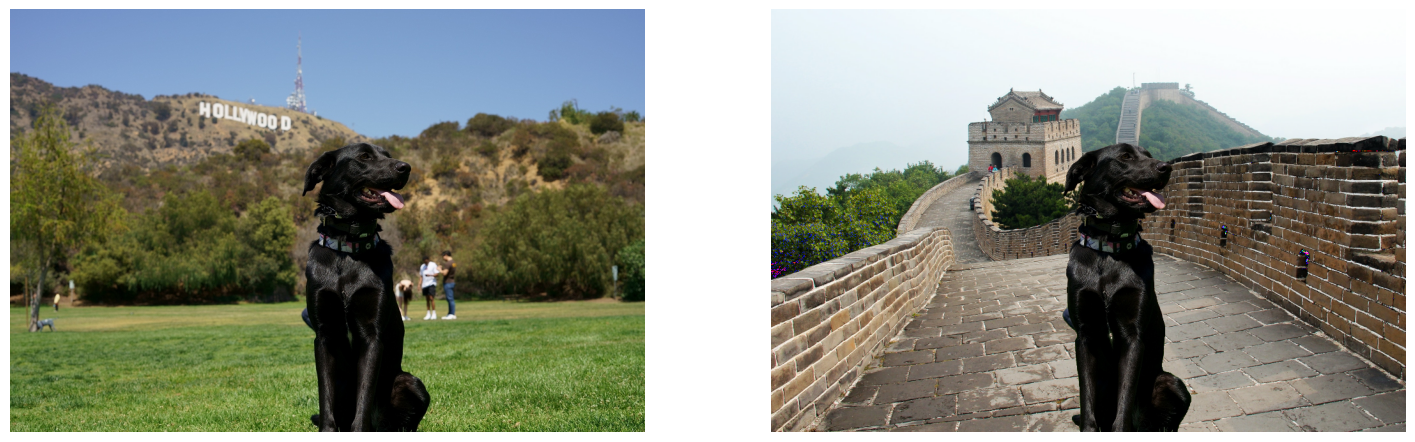

In [11]:
BACKGROUND_FILE = f"{IMAGE_DIR}/wall.jpg"
OUTPUT_DIR = "output"

os.makedirs(name=OUTPUT_DIR, exist_ok=True)

background_image = cv2.cvtColor(src=cv2.imread(filename=BACKGROUND_FILE), code=cv2.COLOR_BGR2RGB)
background_image = cv2.resize(src=background_image, dsize=(image.shape[1], image.shape[0]))

# Set all the foreground pixels from the result to 0
# in the background image and add the image with the background removed.
background_image[resized_result == 1] = 0
new_image = background_image + bg_removed_result

# Save the generated image.
new_image_path = Path(f"{OUTPUT_DIR}/{IMAGE_PATH.stem}-{Path(BACKGROUND_FILE).stem}.jpg")
cv2.imwrite(filename=str(new_image_path), img=cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))

# Display the original image and the image with the new background side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].imshow(image)
ax[1].imshow(new_image)
for a in ax:
    a.axis("off")
plt.show()

# Create a link to download the image.
image_link = FileLink(new_image_path)
image_link.html_link_str = "<a href='%s' download>%s</a>"
display(
    HTML(
        f"The generated image <code>{new_image_path.name}</code> is saved in "
        f"the directory <code>{new_image_path.parent}</code>. You can also "
        "download the image by clicking on this link: "
        f"{image_link._repr_html_()}"
    )
)

## References

* [PIP install openvino-dev](https://github.com/openvinotoolkit/openvino/blob/releases/2021/3/docs/install_guides/pypi-openvino-dev.md)
* [Model Optimizer Documentation](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_prepare_model_convert_model_Converting_Model_General.html)
* [U^2-Net](https://github.com/xuebinqin/U-2-Net)
* U^2-Net research paper: [U^2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/pdf/2005.09007.pdf)